In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## arrange data
female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]
f_df= female_df.groupby(['age','uuid']).mean()

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4','e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33']
f_df.reset_index(inplace=True)
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)

In [6]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
if 90 in cages:
    cages.remove(90)
    
m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

# use the same number of mice per age - only age 80

# Get indices of rows where age is 80
indices = m_data[m_data.index.get_level_values('age') == 80].index
# Choose a random index
np.random.seed(0)
random_index = np.random.choice(indices)
# Remove the row with the selected index
m_data = m_data.drop(random_index)

In [7]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)
data=pd.concat([m_data,f_data])

In [8]:
male_data=m_norm.copy()
female_data=f_norm.copy()

In [9]:
# choose a model for decoder
clf = PLSRegression(n_components=5)
# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=1000

In [10]:
# predict male age
#prepare data
data=male_data.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [11]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
mse_age = mean_squared_error(y_age, y_pred)
print(r2_age)

0.7318470730769663


In [12]:
data=female_data.copy()
y_psd =data.index.get_level_values('age').to_numpy()
X=female_data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [13]:
#decoder
y_pred_psd = cross_val_predict(clf, X, y_psd, cv=cv)
r2_psd = r2_score(y_psd, y_pred_psd)
mse_psd = mean_squared_error(y_psd, y_pred_psd)
print(r2_psd)
print(mse_psd)

0.7068319788725801
170.06565464413265


In [14]:
## train regressor on male predict on female

In [15]:
## female prediction from male regressor
y_train =male_data.index.get_level_values('age').to_numpy()
X_train=male_data.to_numpy()
clf.fit(X_train, y_train)

X_test=female_data.to_numpy()
y_f_from_m = clf.predict(X_test)
r2_f_from_m = r2_score(y_psd, y_f_from_m)
print(r2_f_from_m)

0.2625201414360365


In [16]:
## male prediction from female regressor
y_train =female_data.index.get_level_values('age').to_numpy()
X_train=female_data.to_numpy()
clf.fit(X_train, y_train)


X_test=male_data.to_numpy()
y_m_from_f = clf.predict(X_test)

r2_m_from_f = r2_score(y_age, y_m_from_f)
print(r2_m_from_f)

0.5319442341918201


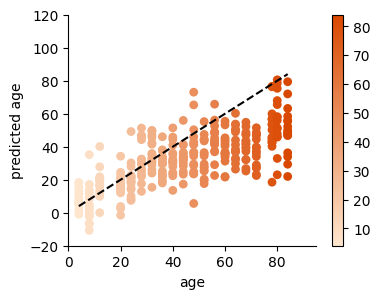

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y_psd, y=y_f_from_m, 
            s=40, 
            c=y_psd, 
            edgecolor='none',
            linewidth=0.25,
            #norm='log',
            cmap=cmf)
sns.despine()
norm = plt.Normalize(y_psd.min(), y_psd.max())
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])
plt.ylim([-20, 120])
plt.xlim([0, 95])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.plot(y_psd, y_psd, linestyle='--', color='black')
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'decoder_predicted_female_from_male.pdf', bbox_inches='tight')

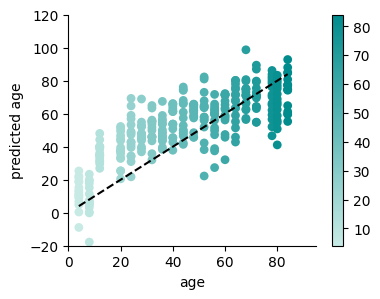

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y_age, y=y_m_from_f, 
            s=40, 
            c=y_age, 
            edgecolor='none',
            linewidth=0.25,
            #norm='log',
            cmap=cmm)
sns.despine()
norm = plt.Normalize(y_age.min(), y_age.max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])
plt.ylim([-20, 120])
plt.xlim([0, 95])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.plot(y_age, y_age, linestyle='--', color='black')
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'decoder_male_from_female.pdf', bbox_inches='tight')

In [19]:
## plot r2 for all options

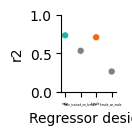

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(0.7,1)
sns.scatterplot(x=[1,2,3,4],y=[r2_age,r2_m_from_f,r2_psd,r2_f_from_m], 
                #join=False, 
              color=['#20B2AA','gray','#f16913','gray'],
              s=25)
plt.ylim([0, 1])
plt.xlim([0.75, 4.25])
plt.xlabel('Regressor design')
plt.ylabel('r2')
plt.xticks(range(1, 5))
plt.gca().set_xticklabels(['male','male_trained_on_female','female','female_on_male'],fontsize=2)
sns.despine()
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'fvm_decoders_r2.pdf', bbox_inches='tight')